In [16]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

DATA_PATH = './../../data/RaidiumImages/'
os.makedirs(f'{DATA_PATH}NPZ', exist_ok=True)
os.makedirs(f'{DATA_PATH}NPZ/train', exist_ok=True)
os.makedirs(f'{DATA_PATH}NPZ/test', exist_ok=True)

In [17]:
# Set folder path
folder_path = f'{DATA_PATH}X_train/'
output_folder_path = f'{DATA_PATH}NPZ/train'

# Loop over PNG files in folder
for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith('.png'):
        # Load PNG file
        img = Image.open(os.path.join(folder_path, filename))

        # Convert image to NumPy array
        arr = np.array(img)

        # Save array to NPZ file
        np.savez_compressed(os.path.join(output_folder_path, f'{filename[:-4]}.npz'), arr=arr)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
# Set folder path
folder_path = f'{DATA_PATH}X_test/'
output_folder_path = f'{DATA_PATH}NPZ/test'

# Loop over PNG files in folder
for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith('.png'):
        # Load PNG file
        img = Image.open(os.path.join(folder_path, filename))

        # Convert image to NumPy array
        arr = np.array(img)

        # Save array to NPZ file
        np.savez_compressed(os.path.join(output_folder_path, f'{filename[:-4]}.npz'), arr=arr)

  0%|          | 0/500 [00:00<?, ?it/s]

# preprocessing with GT

In [100]:
import os
import numpy as np
from PIL import Image

def png_to_npz(img_dir, gt_dir, output_dir):
    # Get a list of all image files in the input directory
    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])

    # Loop over each image file and convert it to an npz file
    for img_file in img_files:
        # Load the image and convert it to an array
        img_path = os.path.join(img_dir, img_file)
        img = Image.open(img_path).convert('RGB')
        img_arr = np.array(img)

        # Load the mask and convert it to an array
        mask_file = img_file.replace('.png', '.png')
        mask_path = os.path.join(gt_dir, mask_file)
        mask = Image.open(mask_path).convert('L')
        mask_arr = np.array(mask)

        # Save the image and mask as a single npz file
        output_file = os.path.join(output_dir, img_file.replace('.png', '.npz'))
        np.savez(output_file, imgs=img_arr, gts=mask_arr)

# Example usage
img_dir = './../../data/RaidiumImages/X_train/'
gt_dir = './../../data/RaidiumImages/Supp_train/segmentations/'
output_dir = './../../data/RaidiumImages/NPZ/train/'
png_to_npz(img_dir, gt_dir, output_dir)

# Visualization

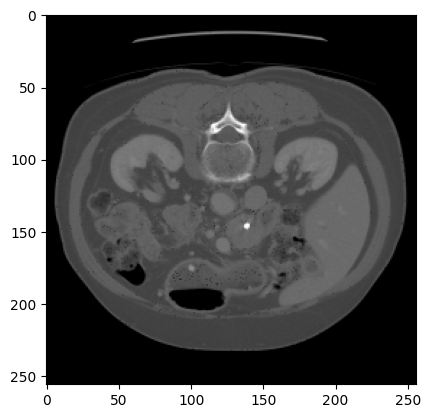

In [19]:
MEDSAM_DATA_PATH = './../../data/medsam/'
# Load NPZ file
data = np.load(f'{MEDSAM_DATA_PATH}/output/CT_Abd-Gallbladder/train/CT_Abd-Gallbladder_FLARE22_Tr_0001.npz')

# Load the values associated with a key
img_array = data['imgs']

# Display the first image
plt.imshow(img_array[0])
plt.show()


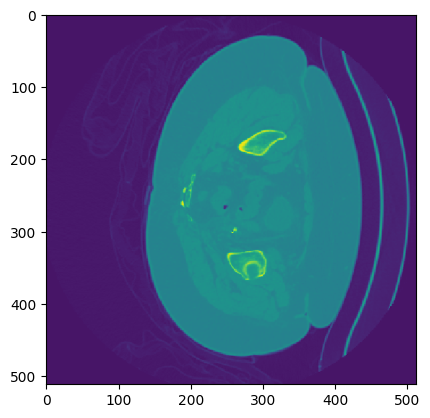

In [20]:
# Load NPZ file
data = np.load(f'{DATA_PATH}/NPZ/train/0.npz')

# Load the values associated with a key
img_array = data['arr']
img_array = img_array.reshape((512, 512))
# Display the first image
plt.imshow(img_array)
plt.show()


# inference

In [1]:
# %% load environment
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from tqdm import tqdm
import argparse
import traceback


In [21]:
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    


def compute_dice(mask_gt, mask_pred):
    """Compute soerensen-dice coefficient.
    Returns:
    the dice coeffcient as float. If both masks are empty, the result is NaN
    """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    if volume_sum == 0:
        return np.NaN
    volume_intersect = (mask_gt & mask_pred).sum()
    return 2*volume_intersect / volume_sum

def finetune_model_predict(img_np, box_np, sam_trans, sam_model_tune, device='cuda:0'):
    H, W = img_np.shape[:2]
    resize_img = sam_trans.apply_image(img_np)
    resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
    input_image = sam_model_tune.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
    with torch.no_grad():
        image_embedding = sam_model_tune.image_encoder(input_image.to(device)) # (1, 256, 64, 64)
        # convert box to 1024x1024 grid
        box = sam_trans.apply_boxes(box_np, (H, W))
        box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
        if len(box_torch.shape) == 2:
            box_torch = box_torch[:, None, :] # (B, 1, 4)
        
        sparse_embeddings, dense_embeddings = sam_model_tune.prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
        )
        medsam_seg_prob, _ = sam_model_tune.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model_tune.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
            )
        medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    return medsam_seg


In [ ]:
# #%% run inference
# # set up the parser
# parser = argparse.ArgumentParser(description='run inference on testing set based on MedSAM')
# parser.add_argument('-i', '--data_path', type=str, default='data/Test', help='path to the data folder')
# parser.add_argument('-o', '--seg_path_root', type=str, default='data/Test_MedSAMBaseSeg', help='path to the segmentation folder')
# parser.add_argument('--seg_png_path', type=str, default='data/sanity_test/Test_MedSAMBase_png', help='path to the segmentation folder')
# parser.add_argument('--model_type', type=str, default='vit_b', help='model type')
# parser.add_argument('--device', type=str, default='cuda:0', help='device')
# parser.add_argument('-chk', '--checkpoint', type=str, default='work_dir/MedSAM/medsam_20230423_vit_b_0.0.1.pth', help='path to the trained model')
# args = parser.parse_args()


In [80]:
device = "cpu"
model_type = "vit_b"
data_path = "./../../data/RaidiumImages/NPZ/"
seg_png_path = "./../../data/RaidiumImages/Test_MedSAMBase_png"
seg_path_root = "./../../data/RaidiumImages/output/"

In [84]:
sam_model_tune = sam_model_registry[model_type]().to(device)
sam_trans = ResizeLongestSide(sam_model_tune.image_encoder.img_size)

npz_folders = sorted(os.listdir(data_path))
os.makedirs(seg_png_path, exist_ok=True)
print(npz_folders)


['train']


In [92]:
#% load MedSAM model
for npz_folder in npz_folders:
    npz_data_path = join(data_path, npz_folder)
    save_path = join(seg_path_root, npz_folder)
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
        npz_files = sorted(os.listdir(npz_data_path))
        for npz_file in tqdm(npz_files):
            try:
                npz = np.load(join(npz_data_path, npz_file))
                ori_imgs = npz['imgs']
                ori_gts = npz['gts']

                sam_segs = []
                sam_bboxes = []
                sam_dice_scores = []

                for img_id, ori_img in enumerate(ori_imgs):
                    # get bounding box from mask
                    gt2D = ori_gts[img_id]
                    y_indices, x_indices = np.where(gt2D > 0)
                    x_min, x_max = np.min(x_indices), np.max(x_indices)
                    y_min, y_max = np.min(y_indices), np.max(y_indices)
                    # add perturbation to bounding box coordinates
                    H, W = gt2D.shape
                    x_min = max(0, x_min - np.random.randint(0, 20))
                    x_max = min(W, x_max + np.random.randint(0, 20))
                    y_min = max(0, y_min - np.random.randint(0, 20))
                    y_max = min(H, y_max + np.random.randint(0, 20))
                    bbox = np.array([x_min, y_min, x_max, y_max])
                    seg_mask = finetune_model_predict(ori_img, bbox, sam_trans, sam_model_tune, device=device)
                    sam_segs.append(seg_mask)
                    sam_bboxes.append(bbox)
                    # these 2D dice scores are for debugging purpose. 
                    # 3D dice scores should be computed for 3D images
                    sam_dice_scores.append(compute_dice(seg_mask>0, gt2D>0))
                
                # # save npz, including sam_segs, sam_bboxes, sam_dice_scores
                # np.savez_compressed(join(save_path, npz_file), medsam_segs=sam_segs, gts=ori_gts, sam_bboxes=sam_bboxes)

#                 # visualize segmentation results
#                 img_id = np.random.randint(0, len(ori_imgs))
#                 # show ground truth and segmentation results in two subplots
#                 fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#                 axes[0].imshow(ori_imgs[img_id])
#                 show_box(sam_bboxes[img_id], axes[0])
#                 show_mask(ori_gts[img_id], axes[0])
#                 axes[0].set_title('Ground Truth')
#                 axes[0].axis('off')

#                 axes[1].imshow(ori_imgs[img_id])
#                 show_box(sam_bboxes[img_id], axes[1])
#                 show_mask(sam_segs[img_id], axes[1])
#                 axes[1].set_title('MadSAM: DSC={:.3f}'.format(sam_dice_scores[img_id]))
#                 axes[1].axis('off')
#                 # save figure
#                 fig.savefig(join(args.seg_png_path, npz_file.split('.npz')[0]+'.png'))
#                 # close figure
#                 plt.close(fig)
            except Exception:
                traceback.print_exc()
                print(f'error in {npz_file}')


os.removedirs('./../../data/RaidiumImages/output/train')
# os.removedirs('./../../data/RaidiumImages/output/test')

  0%|          | 0/1000 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got

error in 0.npz
error in 1.npz
error in 10.npz
error in 100.npz
error in 101.npz
error in 102.npz
error in 103.npz
error in 104.npz
error in 105.npz
error in 106.npz
error in 107.npz
error in 108.npz
error in 109.npz
error in 11.npz
error in 110.npz
error in 111.npz
error in 112.npz
error in 113.npz
error in 114.npz
error in 115.npz
error in 116.npz
error in 117.npz
error in 118.npz
error in 119.npz
error in 12.npz
error in 120.npz
error in 121.npz
error in 122.npz
error in 123.npz
error in 124.npz
error in 125.npz
error in 126.npz
error in 127.npz
error in 128.npz
error in 129.npz
error in 13.npz
error in 130.npz
error in 131.npz
error in 132.npz
error in 133.npz
error in 134.npz
error in 135.npz
error in 136.npz
error in 137.npz
error in 138.npz
error in 139.npz
error in 14.npz
error in 140.npz
error in 141.npz
error in 142.npz
error in 143.npz
error in 144.npz
error in 145.npz
error in 146.npz
error in 147.npz
error in 148.npz
error in 149.npz
error in 15.npz
error in 150.npz
error i

Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got

error in 159.npz
error in 16.npz
error in 160.npz
error in 161.npz
error in 162.npz
error in 163.npz
error in 164.npz
error in 165.npz
error in 166.npz
error in 167.npz
error in 168.npz
error in 169.npz
error in 17.npz
error in 170.npz
error in 171.npz
error in 172.npz
error in 173.npz
error in 174.npz
error in 175.npz
error in 176.npz
error in 177.npz
error in 178.npz
error in 179.npz
error in 18.npz
error in 180.npz
error in 181.npz
error in 182.npz
error in 183.npz
error in 184.npz
error in 185.npz
error in 186.npz
error in 187.npz
error in 188.npz
error in 189.npz
error in 19.npz
error in 190.npz
error in 191.npz
error in 192.npz
error in 193.npz
error in 194.npz
error in 195.npz
error in 196.npz
error in 197.npz
error in 198.npz
error in 199.npz
error in 2.npz
error in 20.npz
error in 200.npz
error in 201.npz
error in 202.npz
error in 203.npz
error in 204.npz
error in 205.npz
error in 206.npz
error in 207.npz
error in 208.npz
error in 209.npz
error in 21.npz
error in 210.npz
error

Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got

error in 293.npz
error in 294.npz
error in 295.npz
error in 296.npz
error in 297.npz
error in 298.npz
error in 299.npz
error in 3.npz
error in 30.npz
error in 300.npz
error in 301.npz
error in 302.npz
error in 303.npz
error in 304.npz
error in 305.npz
error in 306.npz
error in 307.npz
error in 308.npz
error in 309.npz
error in 31.npz
error in 310.npz
error in 311.npz
error in 312.npz
error in 313.npz
error in 314.npz
error in 315.npz
error in 316.npz
error in 317.npz
error in 318.npz
error in 319.npz
error in 32.npz
error in 320.npz
error in 321.npz
error in 322.npz
error in 323.npz
error in 324.npz
error in 325.npz
error in 326.npz
error in 327.npz
error in 328.npz
error in 329.npz
error in 33.npz
error in 330.npz
error in 331.npz
error in 332.npz
error in 333.npz
error in 334.npz
error in 335.npz
error in 336.npz
error in 337.npz
error in 338.npz
error in 339.npz
error in 34.npz
error in 340.npz
error in 341.npz
error in 342.npz
error in 343.npz
error in 344.npz
error in 345.npz
erro

Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got

error in 454.npz
error in 455.npz
error in 456.npz
error in 457.npz
error in 458.npz
error in 459.npz
error in 46.npz
error in 460.npz
error in 461.npz
error in 462.npz
error in 463.npz
error in 464.npz
error in 465.npz
error in 466.npz
error in 467.npz
error in 468.npz
error in 469.npz
error in 47.npz
error in 470.npz
error in 471.npz
error in 472.npz
error in 473.npz
error in 474.npz
error in 475.npz
error in 476.npz
error in 477.npz
error in 478.npz
error in 479.npz
error in 48.npz
error in 480.npz
error in 481.npz
error in 482.npz
error in 483.npz
error in 484.npz
error in 485.npz
error in 486.npz
error in 487.npz
error in 488.npz
error in 489.npz
error in 49.npz
error in 490.npz
error in 491.npz
error in 492.npz
error in 493.npz
error in 494.npz
error in 495.npz
error in 496.npz
error in 497.npz
error in 498.npz
error in 499.npz
error in 5.npz
error in 50.npz
error in 500.npz
error in 501.npz
error in 502.npz
error in 503.npz
error in 504.npz
error in 505.npz
error in 506.npz
erro

Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got

error in 549.npz
error in 55.npz
error in 550.npz
error in 551.npz
error in 552.npz
error in 553.npz
error in 554.npz
error in 555.npz
error in 556.npz
error in 557.npz
error in 558.npz
error in 559.npz
error in 56.npz
error in 560.npz
error in 561.npz
error in 562.npz
error in 563.npz
error in 564.npz
error in 565.npz
error in 566.npz
error in 567.npz
error in 568.npz
error in 569.npz
error in 57.npz
error in 570.npz
error in 571.npz
error in 572.npz
error in 573.npz
error in 574.npz
error in 575.npz
error in 576.npz
error in 577.npz
error in 578.npz
error in 579.npz
error in 58.npz
error in 580.npz
error in 581.npz
error in 582.npz
error in 583.npz
error in 584.npz
error in 585.npz
error in 586.npz
error in 587.npz
error in 588.npz
error in 589.npz
error in 59.npz
error in 590.npz
error in 591.npz
error in 592.npz
error in 593.npz
error in 594.npz
error in 595.npz
error in 596.npz
error in 597.npz
error in 598.npz
error in 599.npz
error in 6.npz
error in 60.npz
error in 600.npz
error

Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got

error in 663.npz
error in 664.npz
error in 665.npz
error in 666.npz
error in 667.npz
error in 668.npz
error in 669.npz
error in 67.npz
error in 670.npz
error in 671.npz
error in 672.npz
error in 673.npz
error in 674.npz
error in 675.npz
error in 676.npz
error in 677.npz
error in 678.npz
error in 679.npz
error in 68.npz
error in 680.npz
error in 681.npz
error in 682.npz
error in 683.npz
error in 684.npz
error in 685.npz
error in 686.npz
error in 687.npz
error in 688.npz
error in 689.npz
error in 69.npz
error in 690.npz
error in 691.npz
error in 692.npz
error in 693.npz
error in 694.npz
error in 695.npz
error in 696.npz
error in 697.npz
error in 698.npz
error in 699.npz
error in 7.npz
error in 70.npz
error in 700.npz
error in 701.npz
error in 702.npz
error in 703.npz
error in 704.npz
error in 705.npz
error in 706.npz
error in 707.npz
error in 708.npz
error in 709.npz
error in 71.npz
error in 710.npz
error in 711.npz
error in 712.npz
error in 713.npz
error in 714.npz
error in 715.npz
erro

Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got

error in 806.npz
error in 807.npz
error in 808.npz
error in 809.npz
error in 81.npz
error in 810.npz
error in 811.npz
error in 812.npz
error in 813.npz
error in 814.npz
error in 815.npz
error in 816.npz
error in 817.npz
error in 818.npz
error in 819.npz
error in 82.npz
error in 820.npz
error in 821.npz
error in 822.npz
error in 823.npz
error in 824.npz
error in 825.npz
error in 826.npz
error in 827.npz
error in 828.npz
error in 829.npz
error in 83.npz
error in 830.npz
error in 831.npz
error in 832.npz
error in 833.npz
error in 834.npz
error in 835.npz
error in 836.npz
error in 837.npz
error in 838.npz
error in 839.npz
error in 84.npz
error in 840.npz
error in 841.npz
error in 842.npz
error in 843.npz
error in 844.npz
error in 845.npz
error in 846.npz
error in 847.npz
error in 848.npz
error in 849.npz
error in 85.npz
error in 850.npz
error in 851.npz
error in 852.npz
error in 853.npz
error in 854.npz
error in 855.npz
error in 856.npz
error in 857.npz
error in 858.npz
error in 859.npz
er

Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/var/folders/vz/nf90bfdj7mg7_f82cw3921dh0000gn/T/ipykernel_19536/3063246557.py", line 21, in <module>
    y_indices, x_indices = np.where(gt2D > 0)
ValueError: not enough values to unpack (expected 2, got

# preprocessing CT

In [124]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#%% import packages
import numpy as np
import os
join = os.path.join 
from skimage import transform, io, segmentation
from tqdm import tqdm
import torch
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import argparse



In [ ]:
# # set up the parser
# parser = argparse.ArgumentParser(description='preprocess PNG images')
# parser.add_argument('-i', '--img_path', type=str, default='./../../data/RaidiumImages/X_train', help='path to the PNG images')
# parser.add_argument('-gt', '--gt_path', type=str, default='./../../data/RaidiumImages/Supp_train/segmentations', help='path to the ground truth',)
# parser.add_argument('-o', '--npz_path', type=str, default='./../../data/RaidiumImages/NPZ', help='path to save the npz files')

# parser.add_argument('--image_size', type=int, default=512, help='image size')
# parser.add_argument('--modality', type=str, default='CT', help='modality')
# parser.add_argument('--anatomy', type=str, default='Abd-Gallbladder', help='anatomy')
# parser.add_argument('--img_extension', type=str, default='.png', help='image file extension')
# parser.add_argument('--prefix', type=str, default='CT_Abd-Gallbladder_', help='prefix')
# parser.add_argument('--model_type', type=str, default='vit_b', help='model type')
# parser.add_argument('--checkpoint', type=str, default='work_dir/SAM/sam_vit_b_01ec64.pth', help='checkpoint')
# parser.add_argument('--device', type=str, default='cpu', help='device')
# # seed
# parser.add_argument('--seed', type=int, default=2023, help='random seed')
# args = parser.parse_args()


In [172]:
import pandas as pd
from pathlib import Path

# Define the path to the data directory and load the train labels
DATA_PATH = "./../../data/RaidiumImages/"
data_dir = Path(DATA_PATH)
df = pd.read_csv(data_dir / "Y_train.csv", index_col=0).T

In [186]:
mask = np.int8(df.iloc[0].values.reshape((512, 512)))

In [201]:
np.unique(mask)

array([  0,   1,   4,   5,   9,  30,  32,  38,  42,  47,  61,  62,  73,
        76,  84,  93,  97, 100, 101], dtype=int8)

In [191]:
modality = "CT"
anatomy = "Abd-Gallbladder"
gt_path = './../../data/RaidiumImages/Y_train.csv'
npz_path = './../../data/RaidiumImages/NPZ'
img_path = './../../data/RaidiumImages/X_train'
img_extension = '.png'
seed = 2023

In [200]:
prefix = modality + '_' + anatomy
gt = pd.read_csv(gt_path, index_col=0, engine='pyarrow').T
names = gt.index.tolist()
sorted_filenames = sorted(names, key=lambda x: int(x.split('.')[0]))[:200]
names = [name for name in sorted_filenames if not os.path.exists(join(npz_path, prefix + '_' + name.split('.png')[0]+'.npz'))]
names = [name for name in sorted_filenames if os.path.exists(join(img_path, name.split('.png')[0] + img_extension))]


# split names into training and testing
np.random.seed(seed)
np.random.shuffle(names)
train_names = sorted(names[:int(len(names)*0.8)])
test_names = sorted(names[int(len(names)*0.8):])

# def preprocessing function
def preprocess_png(gt_path, img_path, gt_name, image_name, image_size, sam_model, device='cuda:0'):
    gt_data = io.imread(join(gt_path, gt_name))
    gt_data = np.uint8(gt_data > 0)

    if np.sum(gt_data)>1000:
        imgs = []
        gts =  []
        img_embeddings = []
        assert np.max(gt_data)==1 and np.unique(gt_data).shape[0]==2, 'ground truth should be binary'
        image_data = io.imread(join(img_path, image_name))
        
        gt_resized = transform.resize(gt_data, (image_size, image_size), order=0, preserve_range=True, mode='constant', anti_aliasing=True)
        img_resized = transform.resize(image_data, (image_size, image_size), order=3, preserve_range=True, mode='constant', anti_aliasing=True)
        assert len(img_resized.shape)==3 and img_resized.shape[2]==3, 'image should be 3 channels'
        assert img_resized.shape[0]==gt_resized.shape[0] and img_resized.shape[1]==gt_resized.shape[1], 'image and ground truth should have the same size'
        imgs.append(img_resized)
        assert np.sum(gt_resized)>100, 'ground truth should have more than 100 pixels'
        gts.append(gt_resized)
        
        if sam_model is not None:
            sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
            resize_img = sam_transform.apply_image(img_resized)
            resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
            input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:])
            assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to the specified size'
            
            with torch.no_grad():
                embedding = sam_model.image_encoder(input_image)
                img_embeddings.append(embedding.cpu().numpy()[0])

    if sam_model is not None:
        return imgs, gts, img_embeddings
    else:
        return imgs, gts

#%% prepare the save path
save_path_tr = join(args.npz_path, prefix, 'train')
save_path_ts = join(args.npz_path, prefix, 'test')
os.makedirs(save_path_tr, exist_ok=True)
os.makedirs(save_path_ts, exist_ok=True)

#%% set up the model
sam_model = sam_model_registry[args.model_type](checkpoint=args.checkpoint).to(args.device)

for name in tqdm(train_names):
    image_name = name
    gt_name = name
    imgs, gts, img_embeddings = preprocess_png(args.gt_path, args.img_path, gt_name, image_name, args.image_size, sam_model, device=args.device)
    #%% save to npz file
    if len(imgs)>1:
        imgs = np.stack(imgs, axis=0) # (n, 256, 256, 3)
        gts = np.stack(gts, axis=0) # (n, 256, 256)
        img_embeddings = np.stack(img_embeddings, axis=0) # (n, 1, 256, 64, 64)
        np.savez_compressed(join(save_path_tr, prefix + '_' + gt_name.split('.png')[0]+'.npz'), imgs=imgs, gts=gts, img_embeddings=img_embeddings)

for name in tqdm(test_names):
    image_name = name
    gt_name = name
    imgs, gts = preprocess_png(args.gt_path, args.img_path, gt_name, image_name, args.image_size, sam_model=None, device=args.device)
    #%% save to npz file
    if len(imgs)>1:
        imgs = np.stack(imgs, axis=0) # (n, 256, 256, 3)
        gts = np.stack(gts, axis=0) # (n, 256, 256)
        np.savez_compressed(join(save_path_ts, prefix + '_' + gt_name.split('.png')[0]+'.npz'), imgs=imgs, gts=gts)



['101.png', '110.png', '111.png', '112.png', '114.png', '116.png', '127.png', '131.png', '135.png', '145.png', '15.png', '160.png', '161.png', '166.png', '174.png', '175.png', '176.png', '177.png', '181.png', '183.png', '187.png', '191.png', '198.png', '22.png', '25.png', '28.png', '29.png', '3.png', '34.png', '39.png', '49.png', '52.png', '53.png', '58.png', '63.png', '65.png', '72.png', '77.png', '87.png', '88.png']
